In [1]:
import numpy as np
from sklearn.manifold import TSNE
import h5py
import os
import scipy
import matplotlib.pyplot as plt
from scipy import ndimage
from sklearn.cluster import KMeans
from sklearn.metrics import adjusted_rand_score, normalized_mutual_info_score


def bin_plane(xyz, plane_size, L, num_bins, detector_eff=1.0, axis=1):
    if detector_eff > 1.0:
        raise ValueError("Detector efficiency cannot be over 100%.")
    
    # Create the grid
    grid_range = np.linspace(-plane_size / 2, plane_size / 2, num_bins)
    
    if axis == 0:
        grid = np.array([(-L, x, y) for y in grid_range for x in grid_range], dtype=np.float32)
        B1 = 1
        B2 = 2
    elif axis == 1:
        grid = np.array([(x, -L, y) for y in grid_range for x in grid_range], dtype=np.float32)
        B1 = 0
        B2 = 2
    elif axis == 2:
        grid = np.array([(x, y, -L) for y in grid_range for x in grid_range], dtype=np.float32)
        B1 = 1
        B2 = 0
    else:
        raise ValueError("Invalid axis value. Axis must be 0, 1, or 2.")
    
    # Filter out points that will never hit the plane based on their y-coordinate and the plane's location
    if L > 0:
        xyz = xyz[xyz[:, axis] < 0.0]  # Points above the plane when L > 0 will not hit
    elif L < 0:
        xyz = xyz[xyz[:, axis] > 0.0]  # Points below the plane when L < 0 will not hit

    # Calculate the hit locations on the plane
    k = -L / xyz[:, axis]
    hit_location = k[:, np.newaxis] * xyz

    # Initialize the bins
    bins = np.zeros((num_bins, num_bins), dtype=int)

    N = len(hit_location)
    M = int(detector_eff * N)
    
    keep_idx = np.random.choice(N, M, replace=False)
    hit_location = hit_location[keep_idx]

    # Number of total hits
    nhits = 0

    # Process each hit location
    for hit in hit_location:
        # Check if the hit is within the plane bounds
        if -plane_size / 2 <= hit[B1] <= plane_size / 2 and -plane_size / 2 <= hit[B2] <= plane_size / 2:
            # Find the closest grid point for the hit location
            distance = scipy.spatial.distance.cdist([hit], grid)
            closest_bin = np.argmin(distance)

            # Convert the linear index to 2D index and increment the corresponding bin
            y_idx, x_idx = divmod(closest_bin, num_bins)
            bins[y_idx, x_idx] += 1
            nhits += 1

    return bins.astype(np.int16)

In [2]:
# Enter the detector parameters here
num_bins = 30
plane_size = 100
detector_distance = 10
detector_eff = 1

# Enter the axis where the detector is places (x=0, y=1, z=2)
axis = 1

# Enter the conformation name (static, unaligned, aligned)
conformation = 'static'

# Enter the photon energy (300ev, 600ev, 2000ev)
energy = '600ev'

# How many simulations are there? (should be 100)
number_of_simulations = 100

# Where are the simulations located?
cwd = f"/home/simon/results/last_frame/{energy}"
os.chdir(cwd)

#This here is just so we can extract the axis name (do not change)
axis_name = ''

if axis == 0:
    axis_name = 'x-axis'
if axis == 1:
    axis_name = 'y-axis'
if axis == 2:
    axis_name = 'z-axis'

In [3]:
datasets = []

# For all mutants ...
for path in [f"ubiWT_{conformation}", f"ubi6_{conformation}", f"ubi20_{conformation}", f"ubi35_{conformation}", f"ubi48_{conformation}"]:
    os.chdir(f"{cwd}/{path}")
    print(os.getcwd())

    # open the data file ...
    with h5py.File('data.h5', 'r') as sims:

        # for every simulation ...
        for sim in range(number_of_simulations):
            current_sim = sims[f"sim{sim+1}"]

            # get the positional data ...
            pos_data = np.array(current_sim['unit_displacement'])

            # calculate the explosion pattern
            img = np.ndarray(shape=(int(num_bins),int(num_bins)))
            img = bin_plane(pos_data,plane_size,detector_distance,num_bins,detector_eff,axis)
            
            # flatten it out (for dimensional reduction) and append it to all datasets
            img = img.flatten()
            datasets.append(img)
datasets = np.vstack(datasets)

/home/simon/results/last_frame/600ev/ubiWT_static
/home/simon/results/last_frame/600ev/ubi6_static
/home/simon/results/last_frame/600ev/ubi20_static
/home/simon/results/last_frame/600ev/ubi35_static
/home/simon/results/last_frame/600ev/ubi48_static


Text(0.5, 1.0, 'TSNE, 600ev, static, 30 bins, 0.1 detector dist/size, y-axis')

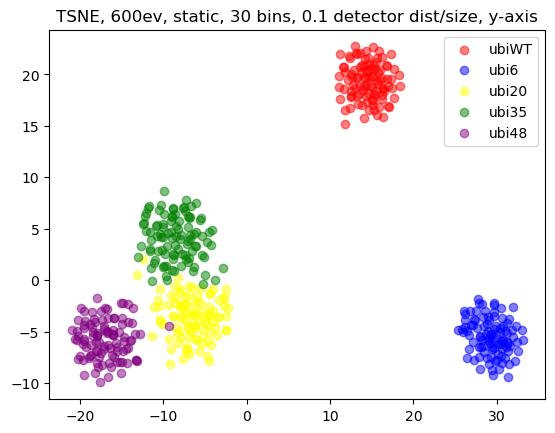

In [4]:
fig = plt.figure()

# Here we perform dimensional reduction to two dimensions
tsne = TSNE(n_components=2)
tsne_results = tsne.fit_transform(datasets)

# For all mutants ...
for data in [['red', list(range(0,100))], ['blue', list(range(100,200))], ['yellow', list(range(200,300))], ['green', list(range(300,400))], ['purple', list(range(400,500))]]:
    x = []
    y = []

    # for every simulation ...
    for sim in data[1]:

        # append and plot the results from dimensional reduction
        x.append(tsne_results[sim][0])
        y.append(tsne_results[sim][1])
    plt.scatter(x, y, color=data[0], alpha=0.5)
plt.legend(['ubiWT','ubi6','ubi20','ubi35','ubi48'])
plt.title(f"TSNE, {energy}, {conformation}, {num_bins} bins, {detector_distance/plane_size} detector dist/size, {axis_name}")

In [ ]:
# Here we calculate the ARI score using k-means where k=5
label = np.concatenate([np.ones(100)*0, np.ones(100)*1, np.ones(100)*2, np.ones(100)*3, np.ones(100)*4])
kmeans = KMeans(n_clusters=5)
cluster_labels = kmeans.fit_predict(tsne_results)
ari_score_tsne = adjusted_rand_score(label, cluster_labels)
print(ari_score_tsne)

0.960913449250269


/home/simon/.conda/envs/explode/lib/python3.8/site-packages/sklearn/cluster/_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
